In [50]:
import pandas as pd
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

## Code for the app

In [1]:
import pandas as pd
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

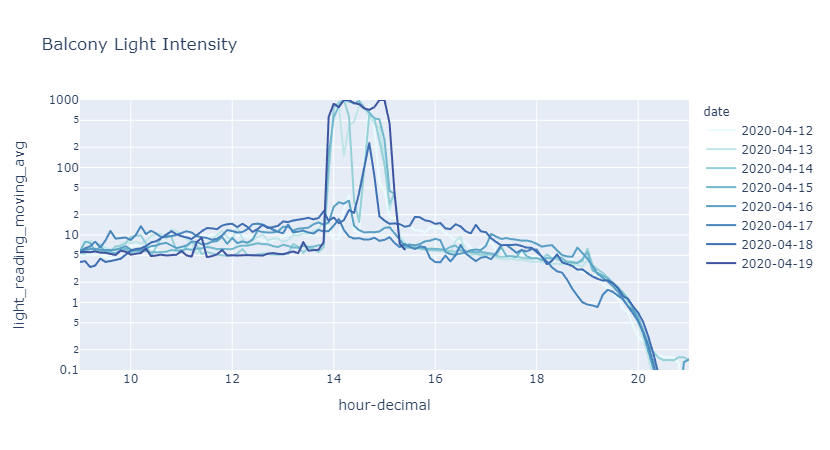

In [17]:
    csv = 'https://raw.githubusercontent.com/archiewood/lightlogger/master/lightlog.csv'
    avg_window=5

    df = pd.read_csv(csv)
    df['date']=df['timestamp'].str[:10]
    df['time']=df['timestamp'].str[10:19]
    df['median']= df['light_reading'].rolling(avg_window).median()
    df['std'] = df['light_reading'].rolling(avg_window).std()
    df = df[(df.light_reading <= df['median']+3*df['std']) & (df.light_reading >= df['median']-3*df['std'])]
    df['light_reading_moving_avg'] = df.iloc[:,1].rolling(window=avg_window).mean()
    
    df['hour']=df['timestamp'].str[11:13].astype(float)
    df['minute']=df['timestamp'].str[14:16].astype(float)
    df['minute_interval']=df['minute'].floordiv(6)
    df['hour-decimal']=df['hour']+df['minute_interval']/10
    df['date']=df['timestamp'].str[:10]
    df
    
    
    piv=df.pivot_table(index=['hour-decimal','date'],values='light_reading_moving_avg').reset_index()
    piv=piv[piv['date']>'2020-04-11']
    piv
    
    
    fig= px.line(piv,x='hour-decimal',y='light_reading_moving_avg',color='date',range_x=[9,21],range_y=[0.1,1000],title='Balcony Light Intensity',log_y=True,color_discrete_sequence=px.colors.sequential.ice_r)

    
    
    fig.show()

In [ ]:
import pandas as pd
import dash
import dash_core_components as dcc
import dash_html_components as html
from dash.dependencies import Input, Output
import plotly.express as px

external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']

def load_graph(is_logged=False):
    csv = 'https://raw.githubusercontent.com/archiewood/lightlogger/master/lightlog.csv'
    avg_window=5

    df = pd.read_csv(csv)
    df['date']=df['timestamp'].str[:10]
    df['time']=df['timestamp'].str[10:19]
    df['median']= df['light_reading'].rolling(avg_window).median()
    df['std'] = df['light_reading'].rolling(avg_window).std()
    df = df[(df.light_reading <= df['median']+3*df['std']) & (df.light_reading >= df['median']-3*df['std'])]
    df['light_reading_moving_avg'] = df.iloc[:,1].rolling(window=avg_window).mean()
    
    df['hour']=df['timestamp'].str[11:13].astype(float)
    df['minute']=df['timestamp'].str[14:16].astype(float)
    df['minute_interval']=df['minute'].floordiv(6)
    df['hour-decimal']=df['hour']+df['minute_interval']/10
    df['date']=df['timestamp'].str[:10]
    
    piv=df.pivot_table(index=['hour-decimal','date'],values='light_reading_moving_avg').reset_index()
    #remove incomplete day's data
    piv=piv[piv['date']>'2020-04-11']
    
    
    if is_logged:
        fig= px.line(piv,x='hour-decimal',y='light_reading_moving_avg',color='date',range_x=[9,21],range_y=[0.1,1000],log_y=True,color_discrete_sequence=px.colors.sequential.Blues)
        fig.update_layout(xaxis_title="Hour of Day",yaxis_title="Balcony Light Intensity",margin=dict(l=50,r=50,b=10,t=10),height=400)
    else:
        fig= px.line(piv,x='hour-decimal',y='light_reading_moving_avg',color='date',range_x=[9,21],range_y=[0,100],color_discrete_sequence=px.colors.sequential.Blues)
        fig.update_layout(xaxis_title="Hour of Day",yaxis_title="Balcony Light Intensity",margin=dict(l=50,r=50,b=10,t=10),height=400)
        
    return fig 


app = dash.Dash(__name__,external_stylesheets=external_stylesheets)
server = app.server

app.title = "Light on my Balcony"

app.layout = html.Div(children=[
    html.H1(children='Light on my Balcony',style={'textAlign': 'left','margin': '0 auto','width': '95%'}
           ),
    dcc.Markdown(children='''
        A web app that shows when there is sunlight on my balcony, as measured by an LDR using a Raspberry Pi. 
    ''',style={'textAlign': 'left','margin': '0 auto','width': '95%'}),
    
    html.Div(
        children=[
            dcc.Graph(id='logged_chart',figure=load_graph(is_logged=True)),
            html.Label('Light Intensity Axis',style={'textAlign':'right'}),
            dcc.RadioItems(
                id='log_switch',
                options=[
                    {'label': 'Linear', 'value': False},
                    {'label': 'Log', 'value': True}
                ],
                value=True,style={'textAlign':'right'}
            ),
            
            dcc.Markdown(children='''
            The source code is on Github for the [visualisation](https://github.com/archiewood/data-display-app/)
            and the [data collection](https://github.com/archiewood/lightlogger/).
            ''')],
        style = { 'margin': '0 auto','width': '95%'}
    )
])

@app.callback(
    Output(component_id='logged_chart', component_property='figure'),
    [Input(component_id='log_switch', component_property='value')]
)
def update_output_chart(log_choice):
    return load_graph(is_logged=log_choice)



if __name__ == '__main__':
    app.run_server(debug=False)


 * Serving Flask app "__main__" (lazy loading)
 * Environment: production
   Use a production WSGI server instead.
 * Debug mode: off


 * Running on http://127.0.0.1:8050/ (Press CTRL+C to quit)
127.0.0.1 - - [19/Apr/2020 16:40:59] "GET / HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2020 16:41:00] "GET /_dash-dependencies HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2020 16:41:00] "GET /_dash-layout HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2020 16:41:00] "GET /assets/favicon.ico?m=1586785331.2378924 HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2020 16:41:01] "POST /_dash-update-component HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2020 16:41:55] "GET /_dash-component-suites/dash_core_components/dash_core_components-shared.js.map HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2020 16:41:55] "GET /_dash-component-suites/dash_core_components/dash_core_components.min.js.map HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2020 16:41:55] "GET /_dash-component-suites/dash_core_components/async-graph.js.map HTTP/1.1" 200 -
127.0.0.1 - - [19/Apr/2020 16:41:55] "GET /_dash-component-suites/dash_html_components/dash_html_components.min.js.map HTTP/1.1" 200 -
127.0.0.1 - - [19/

# Code for testing new dashboards

In [28]:
csv = 'https://raw.githubusercontent.com/archiewood/lightlogger/master/lightlog.csv'
avg_window=5

df = pd.read_csv(csv)
df['date']=df['timestamp'].str[:10]
df['time']=df['timestamp'].str[10:19]
df['median']= df['light_reading'].rolling(avg_window).median()
df['std'] = df['light_reading'].rolling(avg_window).std()
df = df[(df.light_reading <= df['median']+3*df['std']) & (df.light_reading >= df['median']-3*df['std'])]
df['light_reading_moving_avg'] = df.iloc[:,1].rolling(window=avg_window).mean()
    
df['hour']=df['timestamp'].str[11:13].astype(float)
df['minute']=df['timestamp'].str[14:16].astype(float)
df['minute_interval']=df['minute'].floordiv(6)
df['hour-decimal']=df['hour']+df['minute_interval']/10
df['date']=df['timestamp'].str[:10]
    
piv=df.pivot_table(index=['hour-decimal','date'],values='light_reading_moving_avg').reset_index()
    
fig= px.line(piv,x='hour-decimal',y='light_reading_moving_avg',color='date',range_x=[10,20],range_y=[0.1,1000],title='Balcony Light Intensity',log_y=True)


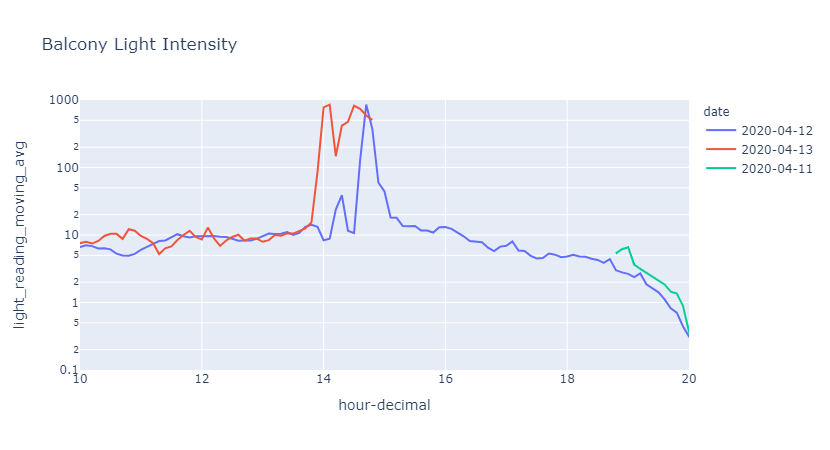

In [29]:
fig.show()